In [1]:
from src.training import *
from src.pipeline.loaders import collate_numpy_matrices_without_conditions
from src.pipeline.datasets import ChunkedDiskCachedDatasetWrapper
import warnings
warnings.filterwarnings("ignore", message="Unknown entity 'ee-infinity-loader'")

has_been_cached = False  # Used to avoid reprocessing our dataset once we've done it once.

# Added something to speed up subsequent training.

dims = (20,20)
if not has_been_cached:
    rv = 5
    datalist = prepare_dataset(dims=dims, repr_version=rv)
    rotational_datalist = AugmentedListDataset(*datalist)
    cached_dataset = ChunkedDiskCachedDatasetWrapper(rotational_datalist,
                                                     # force_rebuild=not has_been_cached,
                                                     cache_dir='dataset_cache')
    # TODO don't i have to save the cache
else:
    cached_dataset = ChunkedDiskCachedDatasetWrapper.from_cache(cache_dir='dataset_cache')

dataloader = DataLoader(
    cached_dataset,
    batch_size=32, 
    collate_fn=collate_numpy_matrices_without_conditions
)
train_dataloader, test_dataloader = split_dataloader(dataloader, val_split=0.2)
train_dataloader, val_dataloader = split_dataloader(train_dataloader, val_split=0.2)

input_size = dims[0]

In [3]:
from src.model import BinaryMatrixTransformCNN, AttentiveBinaryMatrixTransformCNN
from src.training import train_model

model = AttentiveBinaryMatrixTransformCNN(matrix_size=input_size)

train_model(model, train_loader=train_dataloader, val_loader=val_dataloader, integrity_weight=1.0,
            num_epochs=100, device='cpu')

Epoch: 1
Training Loss: 1.3352 (BCE: 0.6810, Integrity: 0.6542)
Validation Loss: 0.3441 (BCE: 0.3410, Integrity: 0.0032)
Validation Accuracy: 97.33%
True Positive Rate: 76.03% | True Negative Rate: 97.62%
Precision: 30.85% | F1 Score: 43.89%
Epoch: 2
Training Loss: 0.2207 (BCE: 0.2183, Integrity: 0.0024)
Validation Loss: 0.1566 (BCE: 0.1544, Integrity: 0.0022)
Validation Accuracy: 97.92%
True Positive Rate: 91.68% | True Negative Rate: 98.01%
Precision: 39.09% | F1 Score: 54.81%
Epoch: 3
Training Loss: 0.1418 (BCE: 0.1396, Integrity: 0.0022)
Validation Loss: 0.1225 (BCE: 0.1208, Integrity: 0.0017)
Validation Accuracy: 98.46%
True Positive Rate: 94.69% | True Negative Rate: 98.51%
Precision: 46.98% | F1 Score: 62.80%
Epoch: 4
Training Loss: 0.1224 (BCE: 0.1203, Integrity: 0.0021)
Validation Loss: 0.1132 (BCE: 0.1114, Integrity: 0.0018)
Validation Accuracy: 98.48%
True Positive Rate: 95.61% | True Negative Rate: 98.52%
Precision: 47.42% | F1 Score: 63.39%
Epoch: 5
Training Loss: 0.1120 (

In [6]:
import torch
from src.model import BinaryMatrixTransformCNN, AttentiveBinaryMatrixTransformCNN
from src.training import test_model

model = AttentiveBinaryMatrixTransformCNN(matrix_size=input_size).to('cpu')
model.load_state_dict(torch.load(f'{model.filename}.pt'))
test_model(model, test_dataloader, device='cpu')

Test Loss: 0.0824 (BCE: 0.0822, Integrity: 0.0014)
Test Accuracy: 99.33%


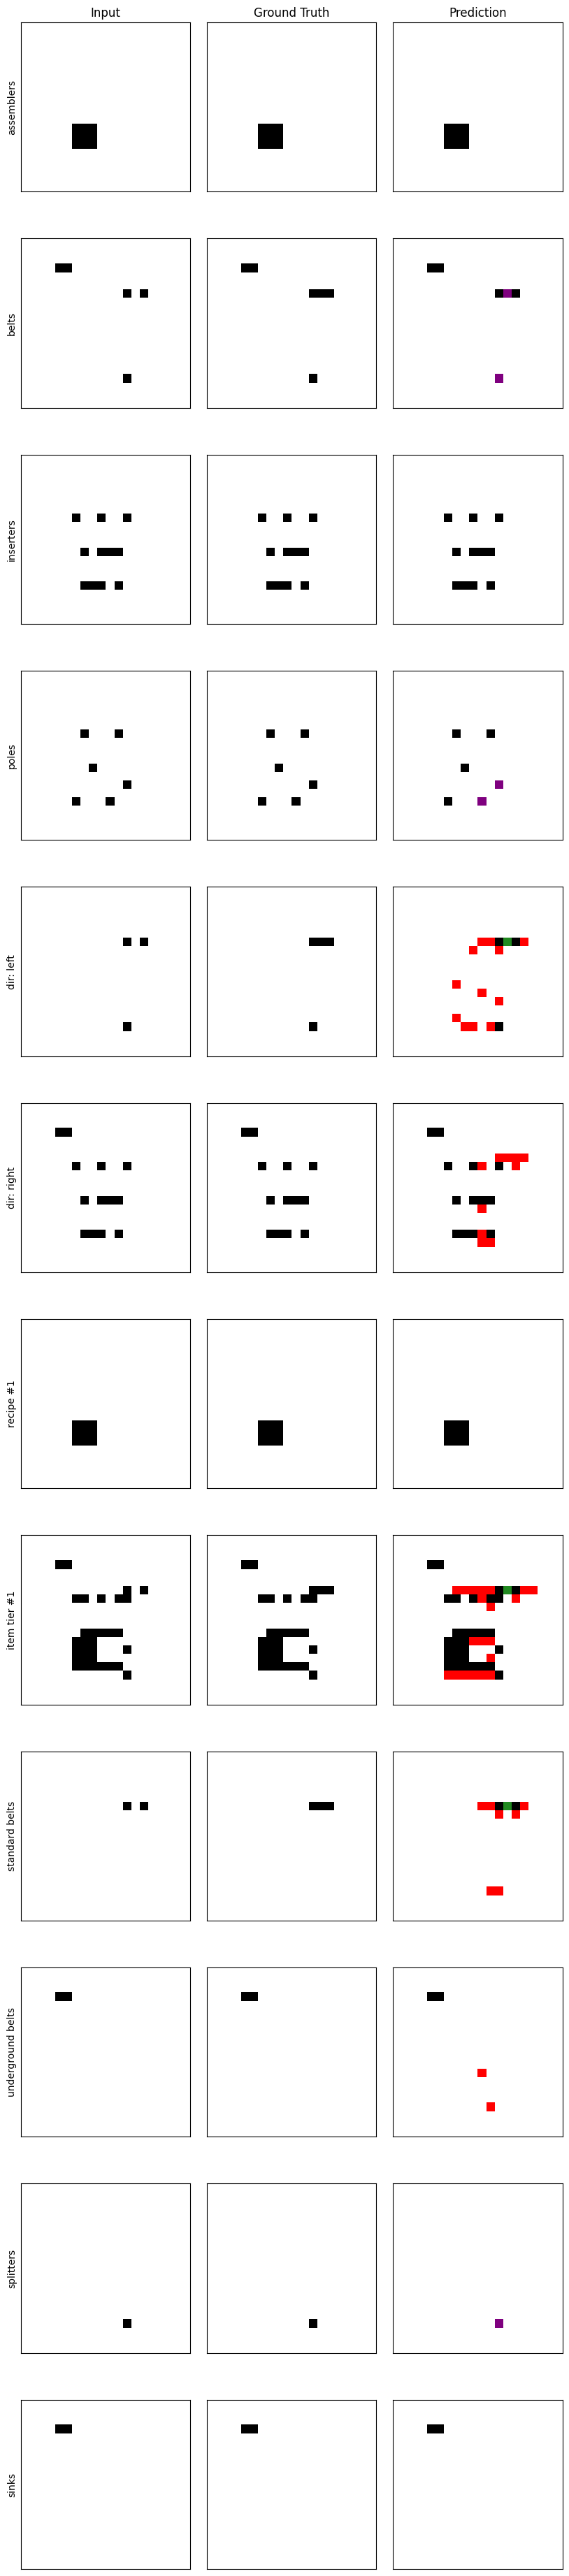

In [7]:
from src.model import BinaryMatrixTransformCNN, AttentiveBinaryMatrixTransformCNN
from src.visualization import visualize_manychannel_matrices
from src.pipeline.loaders import collate_numpy_matrices_without_conditions
from torch.utils.data import DataLoader
import torch

input_size=20

model = AttentiveBinaryMatrixTransformCNN(matrix_size=input_size)
filename = f"{model.filename}.pt"
model.load_state_dict(torch.load(filename))

dataloader = DataLoader(
    cached_dataset,
    batch_size=1, 
    collate_fn=collate_numpy_matrices_without_conditions
)
number_of_fixes = 2
L = len(list(dataloader))//4
X, Y = list(dataloader)[422 + 0*L]

O = X.clone()
for _ in range(number_of_fixes):
    O = model.predict(O)
visualize_manychannel_matrices(X[0], Y[0], O[0])